In [1]:
import pandas as pd
%matplotlib inline

### TL;DR

In one month there were 118,000 dispensers. The worst 10 HQs sare accounted for by 12 dispensers, with a mean item count of 9165, mean NIC of £66,000, and mean OOPE of £5770. 3.5% of prescription items have OOPEs added (compared with 0% for the best dispensers). In a single month these 12 dispensers charged £69,000 in OOPE, equivalent to a 9% surcharge. Compare this with 67% of dispensers have NO OOPE at all.


# What are items are generating the most OOPE?

* The most expensive single presentation is Cinacalcet HCl_Tab 30mg, costing £16,000 per month in OOPE
  * Calcium and Magnesium supplements overall cost £25,000 per month in OOPE with a mean OOPE of £3.30
* The most expensive single OOPE is for Tretinoin Cap 10mg with OOPE cost of £80.99
* The most expensive commonly-prescribed presentation is Solgar_Mag Cit Tab 200mg with mean OOPE per item of £9.86
* At a BNF paragraph level, the most expensive things are:
   * Vitamin D (£67,000 per month)
   * Foods for Special Diets (£52,000 per month)
   * Enteral Nutrition (£43,000 per month)

In [48]:
sql = """
SELECT
  SUM(item_count) AS items,
  SUM(item_pay_oope_amt) AS oope,
  bnf_code,
  bnf_name
FROM
  `ebmdatalab.dispensers.dispensing_with_metadata`
WHERE year_month = '201703' 
GROUP BY bnf_code, bnf_name
ORDER BY SUM(item_pay_oope_amt) DESC
LIMIT 1000
"""

items = pd.io.gbq.read_gbq(sql, 'ebmdatalab', dialect='standard')

In [53]:
items['oope_per_item'] = items['oope'] / items['items']
items.head(3)

,items,oope,bnf_code,bnf_name,oope_per_item
0,3290,16130.23,0905012I0AAAAAA,Cinacalcet HCl_Tab 30mg,4.902805
1,2763,12346.06,0606020Z0AAAAAA,Denosumab_Inj 60mg/1ml Pfs,4.468353
2,1150,10347.45,130802000BBATA0,Dermacolor_Camouflage Creme,8.997783


In [56]:
items[items['items'] > 100].sort_values('oope_per_item', ascending=False).head(3)

,items,oope,bnf_code,bnf_name,oope_per_item
58,119,1173.19,090501300BBCNA0,Solgar_Mag Cit Tab 200mg,9.858739
2,1150,10347.45,130802000BBATA0,Dermacolor_Camouflage Creme,8.997783
76,131,976.75,1311020L0CHAABS,ChloraPrep_Soln Applic 3ml,7.456107


In [75]:
# Grouped at BNF paragraph level
items['bnf_para'] = items['bnf_code'].str.slice(0,6)
items.groupby('bnf_para').agg(['mean', 'sum']).sort_values(('oope', 'sum'), ascending=False).head(10)

items                 oope           oope_per_item  \
                  mean     sum         mean       sum          mean   
bnf_para                                                              
090604     7362.910112  655299   750.558539  66799.71      1.654022   
090401      864.757009  185058   245.283785  52490.73      2.384165   
090402     3589.347826  330220   464.477391  42731.92      0.386100   
130802      359.583333    4315  2107.610000  25291.32     10.205371   
090501      597.600000    8964  1657.254667  24858.82      3.298593   
060602      819.250000    3277  3767.602500  15070.41      5.291244   
040202      205.833333    2470   877.387500  10528.65      5.559036   
091000      687.444444    6187  1008.082222   9072.74      3.329533   
090102      901.750000    3607  2134.987500   8539.95      4.827972   
190201    17448.000000   17448  7753.190000   7753.19      0.444360   

                      
                 sum  
bnf_para              
090604    147.207998  
090401    510.211341  
090402     35.521244  
130802    122.464456  
090501     49.478894  
060602     21.164975  
040202     66.708428  
091000     29.965796  
090102     19.311888  
190201      0.444360

## Is there interesting variation for multiples?

In [4]:
# summarise OOPE spending per item, grouped by HQ
sql = """
SELECT
  hq_name,
  COUNT(DISTINCT organisation_code) AS branches,
  SUM(item_count) AS items,
  SUM(item_pay_oope_amt)/SUM(item_count) AS oope_per_item,
  MAX(item_pay_oope_amt/item_count) AS max_oope_per_item
FROM
  `ebmdatalab.dispensers.dispensing_with_metadata`
WHERE year_month = '201703'
GROUP BY
  hq_name
ORDER BY
  oope_per_item DESC
"""
df = pd.io.gbq.read_gbq(sql, 'ebmdatalab', dialect='standard')

In [14]:
print("In a single month, there were {} branches, represented by {} HQs, prescribing {} items".format(
    df['branches'].sum(),
    df['branches'].count(),
    df['items'].sum()))
print("Total OOPE per month £%s" % (round(df['oope_per_item'] * df['items']).sum()))

In a single month, there were 11816 branches, represented by 3762 HQs, prescribing 84970248 items
Total OOPE per month £406966.0


## HQs with highest OOPE per item

The HQ with the highest OOPE per item charges £2.09 for each item on average.

Of the top 10 HQs, only two were multiples (i.e. associated with more than contractor/location).


In [13]:
df.head(10)

,hq_name,branches,items,oope_per_item,max_oope_per_item
0,ZAIMRA LTD,1,5196,2.091801,79.00
1,MEDICX A G LIMITED,1,5459,1.679353,73.68
2,MEDI-CALL HEALTHCARE LTD,1,2032,1.438484,79.00
3,JM PATEL LTD,1,9196,1.270876,79.00
4,C.K & SONS PHARMACY,1,5221,0.781268,79.00
5,MERITPLAN LTD,2,8713,0.720877,99.00
6,BESPOKE PHARMACY LTD,3,55939,0.340218,86.99
7,OJELACEUTICALS LIMITED,1,3537,0.303200,36.98
8,MR ANIL KUMAR SHARMA,1,5811,0.293103,86.99
9,SPRING PHARMACY,1,8877,0.279374,50.00


## Distribution of OOPE per item by HQ
The vast, vast majority of HQs have no OOPE at all. All but six have their mean OOPE under 50p; 87% had a mean OOPE of less than 1p.  In the chart, note the log scale!

In [34]:
bins = pd.cut(df.oope_per_item, 209)
df.groupby(bins)['oope_per_item'].agg(['count']).head(10)

,count
oope_per_item,
"(-0.00209, 0.01]",3290
"(0.01, 0.02]",206
"(0.02, 0.03]",90
"(0.03, 0.04]",47
"(0.04, 0.05]",26
"(0.05, 0.0601]",23
"(0.0601, 0.0701]",5
"(0.0701, 0.0801]",8
"(0.0801, 0.0901]",5


Text(0.5, 0, 'Mean OOPE per item (£)')

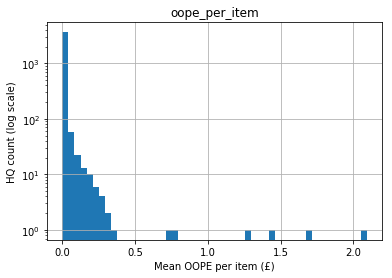

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
df.hist(ax=ax, column=['oope_per_item'], bins=50)
ax.set_yscale('log')
ax.set_ylabel('HQ count (log scale)')
ax.set_xlabel('Mean OOPE per item (£)')

## How does high OOPE covary with group size?

None of the large multiples has high mean OOPEs:

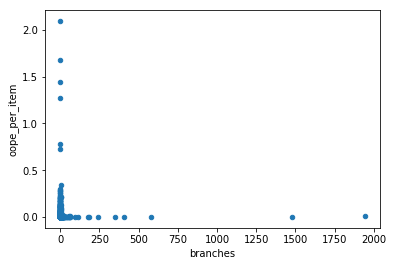

In [172]:
df.plot.scatter(x='branches', y='oope_per_item')

# Is there anything different about the prescriptions being dispensed?

That is, do the HQs with the highest mean OOPE prescribe different amounts of kinds of things from those with the lowest?

In [41]:
print("The 10 HQs with highest mean OOPE account for %s items" % df['items'].head(10).sum())
print("The 10 HQs with lowest mean OOPE account for %s items" % df['items'].tail(10).sum())

The 10 HQs with highest mean OOPE account for 109981 items
The 10 HQs with lowest mean OOPE account for 77398 items


## Investigate lowest and highest HQs

In [43]:
sql = """
SELECT
  item_pay_dr_nic,
  item_count,
  item_pay_oope_amt,
  bnf_code,
  bnf_name,
  name,
  postcode
FROM
  `ebmdatalab.dispensers.dispensing_with_metadata`
WHERE year_month = '201703' AND 
(%s)
"""
hq_names = []
for name in list(df.hq_name.head(10)):
    hq_names.append("hq_name = '%s'" % name)
highest = pd.io.gbq.read_gbq(sql % " OR ".join(hq_names), 'ebmdatalab', dialect='standard')

In [44]:
sql = """
SELECT
  item_pay_dr_nic,
  item_count,
  item_pay_oope_amt,
  bnf_code,
  bnf_name,
  name,
  postcode
FROM
  `ebmdatalab.dispensers.dispensing_with_metadata`
WHERE year_month = '201703' AND 
(%s)
"""
hq_names = []
for name in list(df.hq_name.tail(10)):
    hq_names.append("hq_name = '%s'" % name)
lowest = pd.io.gbq.read_gbq(sql % " OR ".join(hq_names), 'ebmdatalab', dialect='standard')

In [45]:
highest.sort_values('item_pay_oope_amt', ascending=False).head(3)

,item_pay_dr_nic,item_count,item_pay_oope_amt,bnf_code,bnf_name,name,postcode
13629,295.68,82,1849.0,0906040G0AAANAN,Colecal_Cap 800u,MARISCO PHARMACY,LN12 1DP
9201,735.56,65,1664.1,23802098001,H & R_Proshield Plus Skin Prote 115g,BIRKWOOD PHARMACY,DN34 5EN
9492,331.07,55,1664.1,0906040G0BXAAAN,Fultium-D3_Cap 800u,BIRKWOOD PHARMACY,DN34 5EN


### The 10 HQs with highest OOPE per items
...are accounted for by 12 dispensers, with a mean item count of 9165, mean NIC of £66,000, and mean OOPE of £5770. 3.5% of prescription items come with OOPEs (compared with 0 for the best dispensers). In a single month they charged £69,000 in OOPE, equivalent to a 9% surcharge. 67% of dispensers have NO OOPE.

In [89]:
highest.groupby("name").sum()

,item_pay_dr_nic,item_count,item_pay_oope_amt
name,,,
BIRKWOOD PHARMACY,106179.76,19749,10341.15
C K & SONS,33487.40,5221,4079.00
IMPERIUN PHARMACY,24575.03,3537,1072.42
MARISCO PHARMACY,158056.87,20486,6286.61
NEWMARKET PHARMACY,80359.16,15704,2403.70
RYANS LOCAL,22613.05,2032,2923.00
RYANS PHARMACY,49271.80,5196,10869.00
SPRING PHARMACY LTD,83883.55,8877,2480.00
ST STEPHENS CHEMIST,57625.77,8713,6281.00


In [86]:
highest.groupby("name").sum().mean()

item_pay_dr_nic      65986.062500
item_count            9165.083333
item_pay_oope_amt     5774.472500
dtype: float64

### The 10  HQs with lowest OOPE per item 
...are accounted for by 10 dispensers, with a mean item count of 7739, mean NIC of £58,000, and mean OOPE of £0 (indeed, a maximum OOPE of £0)

In [77]:
lowest.head(1)

,item_pay_dr_nic,item_count,item_pay_oope_amt,bnf_code,bnf_name,name,postcode
0,10.86,1,0.0,0702020E0AAAAAA,Clindamycin Phos_Vag Crm 2% + Applic,KEW PHARMACY,IP2 9RR


In [83]:
lowest.groupby("name").sum()

,item_pay_dr_nic,item_count,item_pay_oope_amt
name,,,
BLYTH HEALTH CTRE PHCY LTD,151999.26,19063,0.0
CAPRICORN PHARMACY,44023.27,5289,0.0
HONEYCOMB CHEMIST,56614.86,5497,0.0
J & J PHARMACY LIMITED,26510.56,3166,0.0
KEW PHARMACY,58070.54,6852,0.0
REDCLIFFE PHARMACY,74337.25,8823,0.0
REGENT PHARMACY,57861.14,12721,0.0
SERENA DISPENSING CHEMIST,18414.95,3259,0.0
SPARCELLS PHARMACY,34136.04,4555,0.0


In [87]:
lowest.groupby("name").sum().mean()

item_pay_dr_nic      58227.068
item_count            7739.800
item_pay_oope_amt        0.000
dtype: float64

## Do the highest and lowest dispense very different things?

Descriptive statistics for the "highest" and "lowest" groups are very similar.

The mean OOPE per item in the "highest" group was 11p (and 0 in the "lowest"). The "highest" group had about 1250 presentations not seen in the "lowest" group; for presentations only dispensed in the "highest" group, the mean OOPE per item was 18p; presentations also dispensed in the "lowest" group had a mean OOPE per item of 8p.

Therefore it looks like the "highest" group do routinely add more OOPE for everything; but a lot more for things only they see.




The following shows that in the HQs with the highest OOPE per items, 3746 items were dispensed, with a mean OOPE per item of 11p.

In [94]:
df3 = highest.groupby('bnf_name').sum()
df3['oope_per_item'] = df3['item_pay_oope_amt'] / df3['item_pay_dr_nic']
highest_presentations = df3.sort_values('oope_per_item', ascending=False)
highest_presentations.describe()

,item_pay_dr_nic,item_count,item_pay_oope_amt,oope_per_item
count,3746.000000,3746.000000,3746.000000,3746.000000
mean,211.380873,29.359584,18.498043,0.110807
std,661.259708,129.591249,141.991871,0.736218
min,0.200000,1.000000,0.000000,0.000000
25%,15.930000,1.000000,0.000000,0.000000
50%,49.000000,3.000000,0.000000,0.000000
75%,162.500000,12.000000,0.000000,0.000000
max,14092.550000,2955.000000,3402.160000,15.280992


And the next table shows in the HQs with the lowest OOPE per items, 3368 items were dispensed with a mean OOPE per item of 11p.

In [96]:
df3 = lowest.groupby('bnf_name').sum()
df3['oope_per_item'] = df3['item_pay_oope_amt'] / df3['item_pay_dr_nic']
lowest_presentations = df3.sort_values('oope_per_item', ascending=False)
lowest_presentations.describe()

,item_pay_dr_nic,item_count,item_pay_oope_amt,oope_per_item
count,3368.000000,3368.000000,3368.0,3368.0
mean,172.883219,22.980404,0.0,0.0
std,443.013951,91.813558,0.0,0.0
min,0.220000,1.000000,0.0,0.0
25%,15.330000,1.000000,0.0,0.0
50%,46.250000,3.000000,0.0,0.0
75%,144.975000,10.250000,0.0,0.0
max,10621.800000,1968.000000,0.0,0.0


We can combine the two tables together, to find presentations common to both high and low OOPE dispensers.

In [100]:
# Now compare these
#baddy_presentations = df3[(df3['oope_per_item'] > 0) & (df3['item_count'] > 10)]
compared = highest_presentations.merge(
    lowest_presentations,
    left_index=True,
    right_index=True,
    suffixes=["_high", "_low"],
    how="outer"
)
compared.sort_values("oope_per_item_high", ascending=False).head()

,item_pay_dr_nic_high,item_count_high,item_pay_oope_amt_high,oope_per_item_high,item_pay_dr_nic_low,item_count_low,item_pay_oope_amt_low,oope_per_item_low
bnf_name,,,,,,,,
Orgran_G/F W/F Rice & Millet Spiral,2.42,1.0,36.98,15.280992,NaN,NaN,NaN,NaN
Glutafin_G/F W/F Mini Cracker,2.96,1.0,36.98,12.493243,NaN,NaN,NaN,NaN
Isotard 25 XL_Tab 25mg,6.75,1.0,79.00,11.703704,5.07,3.0,0.0,0.0
Glutafin_G/F W/F Crisp Bread,3.25,1.0,36.98,11.378462,26.00,1.0,0.0,0.0
Solgar_Vit D3 Cap 400u,3.71,1.0,40.00,10.781671,NaN,NaN,NaN,NaN


In [101]:
import numpy as np
good_only = compared[np.isnan(compared['item_count_high'])]
bad_only = compared[np.isnan(compared['item_count_low'])]
both = compared[(~np.isnan(compared['item_count_low'])) & (~np.isnan(compared['item_count_high']))]

There are 870 presentations only prescribed in the dispensaries with the lowest OOPE:

In [102]:
good_only.describe()

,item_pay_dr_nic_high,item_count_high,item_pay_oope_amt_high,oope_per_item_high,item_pay_dr_nic_low,item_count_low,item_pay_oope_amt_low,oope_per_item_low
count,0.0,0.0,0.0,0.0,870.000000,870.000000,870.0,870.0
mean,NaN,NaN,NaN,NaN,68.008460,1.648276,0.0,0.0
std,NaN,NaN,NaN,NaN,140.238044,1.327921,0.0,0.0
min,NaN,NaN,NaN,NaN,0.540000,1.000000,0.0,0.0
25%,NaN,NaN,NaN,NaN,8.672500,1.000000,0.0,0.0
50%,NaN,NaN,NaN,NaN,25.965000,1.000000,0.0,0.0
75%,NaN,NaN,NaN,NaN,66.630000,2.000000,0.0,0.0
max,NaN,NaN,NaN,NaN,1526.090000,14.000000,0.0,0.0


...and 1248 presentations only prescribed in those with the highest OOPE, of which 103 have any OOPE

In [140]:
bad_only[bad_only['item_pay_oope_amt_high'] > 0].describe()

,item_pay_dr_nic_high,item_count_high,item_pay_oope_amt_high,oope_per_item_high,item_pay_dr_nic_low,item_count_low,item_pay_oope_amt_low,oope_per_item_low
count,103.000000,103.000000,103.000000,103.000000,0.0,0.0,0.0,0.0
mean,143.842233,3.349515,92.444563,2.181023,NaN,NaN,NaN,NaN
std,179.986913,4.471497,112.231331,3.011054,NaN,NaN,NaN,NaN
min,2.420000,1.000000,36.980000,0.089936,NaN,NaN,NaN,NaN
25%,22.960000,1.000000,36.980000,0.388394,NaN,NaN,NaN,NaN
50%,74.800000,2.000000,73.680000,0.824067,NaN,NaN,NaN,NaN
75%,181.970000,4.000000,79.000000,2.690344,NaN,NaN,NaN,NaN
max,1078.580000,29.000000,732.860000,15.280992,NaN,NaN,NaN,NaN


...and 2498 in both, of which 192 have any OOPE:

In [143]:
both[both['item_pay_oope_amt_high'] > 0].describe()

,item_pay_dr_nic_high,item_count_high,item_pay_oope_amt_high,oope_per_item_high,item_pay_dr_nic_low,item_count_low,item_pay_oope_amt_low,oope_per_item_low
count,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.0,192.0
mean,998.646042,41.489583,311.311875,0.991855,609.875781,26.020833,0.0,0.0
std,1938.491243,97.787353,541.544326,1.572385,1213.212406,65.268191,0.0,0.0
min,3.250000,1.000000,36.980000,0.002624,2.780000,1.000000,0.0,0.0
25%,98.657500,4.000000,73.960000,0.171077,38.212500,2.000000,0.0,0.0
50%,346.220000,10.500000,110.940000,0.525264,172.040000,5.500000,0.0,0.0
75%,914.370000,44.500000,237.000000,1.066454,658.497500,24.250000,0.0,0.0
max,14092.550000,1101.000000,3402.160000,11.703704,10621.800000,759.000000,0.0,0.0


In [147]:
# Total OOPE spent per item, for things prescribed in both places - top 5 (of 192 with any OOPE)
both[both['item_pay_oope_amt_high'] > 0]['oope_per_item_high'].sort_values(ascending=False).head()

bnf_name
Isotard 25 XL_Tab 25mg          11.703704
Glutafin_G/F W/F Crisp Bread    11.378462
Glutafin_G/F W/F Cornflakes      7.084291
Juvela_G/F W/F Pure Oats         6.651079
Nifedipine_Cap 10mg M/R          5.238727
Name: oope_per_item_high, dtype: float64

In [148]:
# Total OOPE spent per item, for things prescribed in only high-oope places - top 5 (of 103 with any OOPE)
bad_only[bad_only['item_pay_oope_amt_high'] > 0]['oope_per_item_high'].sort_values(ascending=False).head()

bnf_name
Orgran_G/F W/F Rice & Millet Spiral    15.280992
Glutafin_G/F W/F Mini Cracker          12.493243
Solgar_Vit D3 Cap 400u                 10.781671
Bio-Vitamin D3_Cap 1000u               10.321847
Dermacolor_Camouflage Creme             9.000000
Name: oope_per_item_high, dtype: float64

# Finally, there is a weird £36.98 thing going on
I've noticed a lot of the things with high OOPE have identical OOPE-per item - for example, £20.99 and £36.98, both examined here.

These appear to be fixed OOPE prices, regardless of the item - for example, the relatively common `Bio-Vitamin D3_Cap 800u` costs 44p per pack, but £36.98 fixed OOPE.

At the other end, an unusual special like `Levocarnitine_Oral Soln Paed 1.5g/5ml` costs £1571 per pack, and still £36.98 fixed OOPE.



In [150]:
sql = """
SELECT
  *
FROM
  dispensers.dispensing_with_metadata
WHERE
  (item_pay_oope_amt / item_count = 36.98) OR (item_pay_oope_amt / item_count) = 20.99
  AND year_month = '201703'
"""
df = pd.io.gbq.read_gbq(sql, 'ebmdatalab', dialect='standard')


In [162]:
df['oope_per_nic'] = (df['item_pay_oope_amt'] / df['item_count']) / df['item_pay_dr_nic']

In [154]:
print("A total of {} spent in OOPE for items with OOPE at these two levels".format(df['item_pay_oope_amt'].sum()))

A total of 654318.43 spent in OOPE for items with OOPE at these two levels


In [165]:
df[['bnf_name', 'bnf_code', 'item_pay_dr_nic', 'item_pay_oope_amt', 'oope_per_nic']].sort_values('oope_per_nic', ascending=False)

,bnf_name,bnf_code,item_pay_dr_nic,item_pay_oope_amt,oope_per_nic
34,Aloe Pura_Aloe Vera Max Strgh Juice,091104000BBJUA0,0.01,20.99,2099.000000
4318,Lamb_Pure Fish Oil Cap 1100mg,090601100BBGSA0,0.10,36.98,369.800000
5145,Lamb_Nicotinamide Tab 250mg (8054),090602200BBBHA0,0.31,36.98,119.290323
5105,Ergocalciferol_Tab 12.5mcg,0906040N0AAEWEW,0.37,36.98,99.945946
5512,Bio-Vitamin D3_Cap 800u,0906040G0CEAAAN,0.44,73.96,84.045455
6389,Solgar_Vit D3 Cap 400u,0906040G0BEAEBI,0.46,36.98,80.391304
5070,"Solgar_Vit D3 Tab 1,000u",0906040G0BEACBG,0.55,36.98,67.236364
2971,"Solgar_Vit D3 Cap 1,000u",0906040G0BEADBH,0.56,36.98,66.035714
1163,"Colecal_Tab 2,000u",0906040G0AADBDB,0.58,73.96,63.758621
5777,"Valupak_Vit D3 Tab 1,000u",0906040G0BMAABG,0.59,36.98,62.677966


A lot of these seem to be devices:

In [161]:
df.groupby('bnf_name').agg('sum')['item_count'].head(100)

bnf_name
3m Health Care_Cavilon Durable Barrier Crm 28g                  11
3m Health Care_Cavilon Durable Barrier Crm 92g                  11
3m Health Care_Cavilon Durable Barrier Crm Sach 2g               2
3m Health Care_Cavilon No Sting 1ml Barrier Film Foam Applic     2
3m Health Care_Cavilon No Sting Barrier Film P/Spy 28ml          9
3m Health Care_Cavilon No Sting Barrier Film Stoma Wipe          2
AMI_Suportx Hernia Support Girdles Male Low Waist(Sml-XXLge)     2
AMI_Suportx Ostomy & A/Support Ladies Shorts Blk Sizes 10-24     2
AMI_Suportx Ostomy Support Mens Trunks D/Grey Marl(Sml-XXLge     1
AMI_Suportx Ostomy/Hernia Easy Peel Support Belt 20cm Med        1
APO-go PFS_Inf 5mg/ml 10ml Pfs                                   1
Accrete D3_Tab                                                   1
Acetylcy_Gran Sach 200mg                                         1
Aciferol D3_Cap 50,000u                                          1
Aciferol D3_Oral Soln 2,000u/ml                      